<a href="https://colab.research.google.com/github/AndreassOlsson/drone-anomalydetection/blob/main/AnomalyDetection_UMCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import bisect
import tarfile
import pickle
from glob import glob
from time import sleep

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn # nn.BCELoss
import torch.optim as optimizer
import torch.nn.functional as F 
import torch.utils.data as data # data.DataLoader, data.Dataset
import torchvision.transforms as transforms # ToTensor
from tqdm import tqdm


np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# !pip install pipreqs

In [7]:
# !pipreqs . 

INFO: Successfully saved requirements file in ./requirements.txt


# Data

In [2]:
tarfile.open(r'/content/drive/MyDrive/Andreas Olsson/Public-Safety/data/UMCD/umcd-extracted.tgz', 'r:gz').extractall()

In [3]:
# def make_tarfile(output_filename, source_dir):
#     with tarfile.open(output_filename, "w:gz") as tar:
#         tar.add(source_dir, arcname=os.path.basename(source_dir))

# make_tarfile(r'/content/drive/MyDrive/Andreas Olsson/Public-Safety/data/UMCD/umcd-normal.tgz', 'umcd-extracted/Normal')

In [4]:
# tarfile.open(r'/content/drive/MyDrive/Andreas Olsson/Public-Safety/data/UMCD/umcd-normal.tgz', 'r:gz').extractall('folder/')

## Inspect a video

In [ ]:
def display_frames(video_path=None, cv2_videocapture=None, n_frames=10, starting_frame=0, interval=30, n_cols=5):
  """
  If cv2_videocapture is provided, it overwrites the video_path
  """
  cap = cv2.VideoCapture(video_path) if not cv2_videocapture else cv2_videocapture
  n_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  frames = [starting_frame + interval * i for i in range(n_frames) if starting_frame + interval * i <= n_frames_total]
  n_frames = len(frames)

  n_rows = bisect.bisect_right([i for i in range(n_frames) if i % n_cols == 0], n_frames)
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
  axs = axs.flatten()

  for i, frame in enumerate(frames):
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
      res, img = cap.read()
      if res:
          axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
          axs[i].set_title(f'Frame: {frame}')
          axs[i].axis('off')

  plt.tight_layout()
  plt.show()
  cap.release()

def inspect_video(video_path=None, cv2_videocapture=None, df=True, n_frames=10, starting_frame=0, interval=30, n_cols=5):
  cap = cv2.VideoCapture(video_path) if not cv2_videocapture else cv2_videocapture
  fs = cap.get(cv2.CAP_PROP_FRAME_COUNT)
  fps = cap.get(cv2.CAP_PROP_FPS)
  height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
  print(f'Videospecs:\nFrames {fs}, FPS {fps}, Height {height}, Width {width}')
  print(f'Shape of np array: {cap.read(0)[1].shape}\n')
  if df: display_frames(cv2_videocapture=cap, n_frames=n_frames, starting_frame=starting_frame, interval=interval, n_cols=n_cols)
  else: cap.release()

Videospecs:
Frames 800.0, FPS 49.967, Height 1080.0, Width 1920.0
Shape of np array: (1080, 1920, 3)



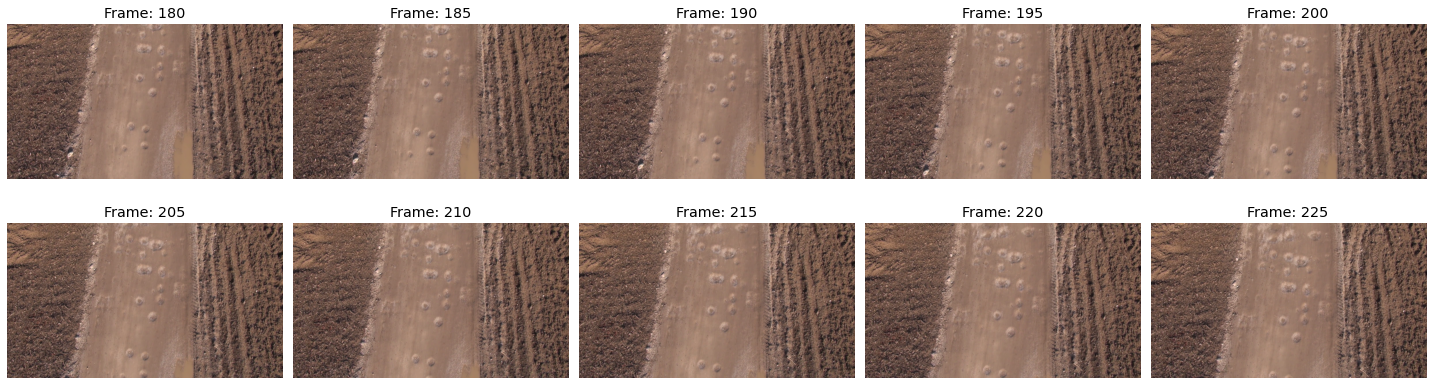

In [ ]:
# inspect_video('/content/umcd-extracted/Normal/Dirt-18-nt.mp4', df=True, starting_frame=180, interval=5)
inspect_video('/content/umcd-extracted/Normal/Dirt-17-nt.mp4', df=True, starting_frame=180, interval=5)

In [ ]:
dirt = [s for s in os.listdir('/content/umcd-extracted/Normal/') if 'Dirt' in s and 'nt' in s]
dirt[:int(len(dirt)*0.7)], dirt[int(len(dirt)*0.7):]

(['Dirt-11-nt.mp4',
  'Dirt-8-nt.mp4',
  'Dirt-12-nt.mp4',
  'Dirt-19-nt.mp4',
  'Dirt-20-nt.mp4',
  'Dirt-7-nt.mp4',
  'Dirt-4-nt.mp4',
  'Dirt-3-nt.mp4',
  'Dirt-13-nt.mp4',
  'Dirt-2-nt.mp4',
  'Dirt-16-nt.mp4',
  'Dirt-9-nt.mp4',
  'Dirt-14-nt.mp4',
  'Dirt-15-nt.mp4'],
 ['Dirt-6-nt.mp4',
  'Dirt-1-nt.mp4',
  'Dirt-10-nt.mp4',
  'Dirt-18-nt.mp4',
  'Dirt-5-nt.mp4',
  'Dirt-17-nt.mp4'])

## Create UMCD DataLoaders

In [ ]:
class UMCD_video_dset(data.Dataset):
  """
  Takes a given number of input frames and tries to predict the next frame
  """
  def __init__(self, video_folder, tfms, target_chw=(3,256,256), n_input_frames=6, specific_videos=None):
    self.video_paths = glob(os.path.join(video_folder, '*.mp4')) if not specific_videos else specific_videos
    self.tfms, self.target_chw = tfms, target_chw

    self.n_input_frames = n_input_frames
    self.n_pred_frames = 1
    self.n = self.n_input_frames + self.n_pred_frames

    self.setup()


  def setup(self):
    frame_intervals = []
    for video_path in self.video_paths:
      print(video_path)
      cap = cv2.VideoCapture(video_path)
      fs = cap.get(cv2.CAP_PROP_FRAME_COUNT)
      fs = int((fs // self.n) * self.n)

      if len(frame_intervals) == 0: frame_intervals = [fs // self.n]
      else: frame_intervals.append(frame_intervals[-1] + fs // self.n)
      cap.release()

    self.frame_intervals = frame_intervals
    

  def __getitem__(self, batch_idx):
    frame_idxs = list(map(lambda x: x + batch_idx * self.n, range(self.n)))
    video_idx = bisect.bisect_right(self.frame_intervals, batch_idx)
    all_frames = torch.empty(self.n, self.target_chw[0], self.target_chw[1], self.target_chw[2])
    
    cap = cv2.VideoCapture(self.video_paths[video_idx])
    for i, frame_idx in enumerate(frame_idxs):
      tup = cap.read(frame_idx)
      assert tup[0] is not None, 'Failed to extract videoframe from videocapture'
      tfmd_frame = self.tfms(tup[1])
      all_frames[i] = tfmd_frame
    cap.release()

    input_frames, target_frames = all_frames[:self.n_input_frames], all_frames[self.n_input_frames:]
    return (input_frames, target_frames.squeeze())


  def __len__(self): 
    return self.frame_intervals[-1]


  def show(self, batch_idx=None):
    batch_idx = batch_idx if batch_idx else random.randint(0, self.frame_intervals[-1])
    tup = self.__getitem__(batch_idx)
    input_frames, target_frame = tup[0].numpy(), tup[1].numpy()

    f, axs = plt.subplots(1, self.n, figsize=(self.n*3, 3))

    for i, img in enumerate(input_frames): 
      axs[i].imshow(cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Input frame {i+1}')
      axs[i].axis('off')

    img = target_frame
    i = self.n_input_frames
    axs[i].imshow(cv2.cvtColor(img.transpose(1,2,0), cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'Target frame')
    axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# The training will be on "normal" videos
video_folder = '/content/umcd-extracted/Normal/'

# np images are in shape h, w, c
# torch wants images of shape c, h, w
# We need to transform the np arrays to PILImages, then to Tensor etc.
target_chw=(3, 256, 256)
tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((target_chw[1], target_chw[2])),
    transforms.ToTensor(),
    ])

n_input_frames = 3

dirt = [video_folder + s for s in os.listdir('/content/umcd-extracted/Normal/') if 'Dirt' in s and 'nt' in s]
train_videos, test_videos = dirt[:int(len(dirt)*0.7)], dirt[int(len(dirt)*0.7):]

train_dset = UMCD_video_dset(video_folder, tfms=tfms, target_chw=target_chw, n_input_frames=n_input_frames, specific_videos=train_videos)
test_dset = UMCD_video_dset(video_folder, tfms=tfms, target_chw=target_chw, n_input_frames=n_input_frames, specific_videos=test_videos)

# train_dset, test_dset = data.random_split(dset, [0.7, 0.3], generator=torch.Generator().manual_seed(42))

train_dl = data.DataLoader(train_dset, batch_size = 32, shuffle = False)
test_dl = data.DataLoader(test_dset, batch_size = 32, shuffle = False)

len(train_dl.dataset), len(test_dl.dataset)

/content/umcd-extracted/Normal/Dirt-11-nt.mp4
/content/umcd-extracted/Normal/Dirt-8-nt.mp4
/content/umcd-extracted/Normal/Dirt-12-nt.mp4
/content/umcd-extracted/Normal/Dirt-19-nt.mp4
/content/umcd-extracted/Normal/Dirt-20-nt.mp4
/content/umcd-extracted/Normal/Dirt-7-nt.mp4
/content/umcd-extracted/Normal/Dirt-4-nt.mp4
/content/umcd-extracted/Normal/Dirt-3-nt.mp4
/content/umcd-extracted/Normal/Dirt-13-nt.mp4
/content/umcd-extracted/Normal/Dirt-2-nt.mp4
/content/umcd-extracted/Normal/Dirt-16-nt.mp4
/content/umcd-extracted/Normal/Dirt-9-nt.mp4
/content/umcd-extracted/Normal/Dirt-14-nt.mp4
/content/umcd-extracted/Normal/Dirt-15-nt.mp4
/content/umcd-extracted/Normal/Dirt-6-nt.mp4
/content/umcd-extracted/Normal/Dirt-1-nt.mp4
/content/umcd-extracted/Normal/Dirt-10-nt.mp4
/content/umcd-extracted/Normal/Dirt-18-nt.mp4
/content/umcd-extracted/Normal/Dirt-5-nt.mp4
/content/umcd-extracted/Normal/Dirt-17-nt.mp4


(1695, 636)

# Model(s)

In [ ]:
class SpatioTemporal_AE(nn.Module):
  def __init__(self, encoder, decoder):
    super(SpatioTemporal_AE, self).__init__()
    
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, videos):
    encoded_input = self.encoder(videos)
    decoded_output = self.decoder(encoded_input)
    return decoded_output

## Encoder

The encoder will take as input:
1. The sequence of tubelets (patches) mapped into tubelet embeddings via a linear projection
 1. Tubelets = *x_k*
 2. Weights of trainable linear projection = *E* 
2. An extra learnable embedding prepended to the sequence of tubelet embeddings
 1. Learnable embedding = *x_cls*
3. Learnable spatiotemporal embeddings added to the tubelet embeddings
 1. Learnable spatiotemporal position embeddings = *E_pos*

Encoder input = [*x_cls*; *x_k_1* * *E*; *x_k_2* * *E*; ... ; *x_k_N* * *E*] + E_pos

In [ ]:
# PyTorch requires images to be in N C H W format
# Apperently this method with nested for loops was faster than nested list comprehensions
def patchify(batch, patch_thw=(3,16,16)):
  N, T, C, H, W = batch.shape
  t, h, w = patch_thw

  assert T % t == 0, 'Number of videoframes is not divisible by the number of frames in each patch'
  assert H % h == 0, 'Videoframe height is not divisible by patch height'
  assert W % w == 0, 'Videoframe width is not divisible by patch width'

  patches = []
  for video in batch:
    video_patches = []
    for f in range(T//t):
      for y in range(H//h):
        for x in range(W//w):
          video_patches.append(video[f*t:(f+1)*t, :, y*h:(y+1)*h, x*w:(x+1)*w].flatten())
          # print(f'Patch {len(patches)}:\t Video {i}\t Frames {f*t}:{(f+1)*t}\t Channels :\t Rows {y*h}:{(y+1)*h}\t Columns {x*w}:{(x+1)*w}')
    
    patches.append(torch.stack(tuple(video_patches)))
  return torch.stack(tuple(patches))


# Test function
sample_batch = torch.rand(7,6,3,256,256)
N, T, C, H, W = sample_batch.shape 
t, h, w = 3, 16, 16

patches = patchify(sample_batch, patch_thw=(t,h,w))

assert patches.shape == (N, (H/h * W/w) * (T/t), t*C*h*w)

patches.shape

torch.Size([7, 512, 2304])

In [ ]:
"Multi-head Self Attention"
class Linear(nn.Module):
  def __init__(self, input_dim=(768,), output_dim=(6, 768//6)):
    super(Linear, self).__init__()

    self.weight = nn.Parameter(torch.randn(*input_dim, *output_dim))
    self.bias = nn.Parameter(torch.randn(*output_dim))

  def forward(self, x, dims):
    return torch.tensordot(x, self.weight, dims=dims) + self.bias


class Multihead_Self_Attention(nn.Module):
  def __init__(self, input_dim=768, n_attention_heads=6):
    super(Multihead_Self_Attention, self).__init__()

    self.input_dim, self.n_attention_heads = input_dim, n_attention_heads

    assert input_dim % n_attention_heads == 0, f'Input dimension is not divisible by number of attention heads'
    
    self.head_dim = input_dim // n_attention_heads

    self.query = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.key = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.value = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.out = Linear(input_dim=(n_attention_heads, self.head_dim), output_dim=(input_dim,))
    
  def forward(self, x):
    # (N, n_embeddings, embedding_dim) --> (N, n_embeddings, n_attention_heads, head_dim) --> (N, n_embeddings, embedding_dim)

    query = self.query(x, dims=([2], [0])).permute(0, 2, 1, 3)
    key = self.key(x, dims=([2], [0])).permute(0, 2, 1, 3)
    value = self.value(x, dims=([2], [0])).permute(0, 2, 1, 3)

    attn_weights = torch.matmul(query, key.transpose(-2,-1)) / self.head_dim ** 0.5
    attn_weights = F.softmax(attn_weights, dim=-1)

    out = torch.matmul(attn_weights, value).permute(0, 2, 1, 3)

    return self.out(out, dims=([2,3],[0,1]))

Multihead_Self_Attention()(torch.randn(7, 99, 768)).shape

torch.Size([7, 99, 768])

In [ ]:
class VisionTransformer_block(nn.Module):
  def __init__(self, input_dim=768, mlp_dim=4096, n_attention_heads=6):
    super(VisionTransformer_block, self).__init__()

    self.norm1 = nn.LayerNorm(input_dim)
    self.attention = Multihead_Self_Attention(input_dim, n_attention_heads)
    self.dropout = nn.Dropout(0.1)
    self.norm2 = nn.LayerNorm(input_dim)
    self.mlp = nn.Sequential(
        nn.Linear(input_dim, mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim, input_dim)
    )

  def forward(self, x):
    residual = x
    out = self.norm1(x)
    out = self.attention(x)
    out = self.dropout(out)
    out = out + residual

    residual = out
    out = self.norm2(out)
    out = self.mlp(out)
    out = out + residual

    return out

VisionTransformer_block()(torch.randn(7, 99, 768)).shape

torch.Size([7, 99, 768])

In [ ]:
class SpatioTemporal_Encoder(nn.Module):
  def __init__(self, video_dim=(6, 3, 256, 256), patch_dim=(3, 16, 16), embedding_dim=768, mlp_dim=1024, n_attention_heads=2, n_transformer_layers=2):
    super(SpatioTemporal_Encoder, self).__init__()

    self.video_dim, self.patch_dim = video_dim, patch_dim
    self.embedding_dim, self.mlp_dim = embedding_dim, mlp_dim
    self.n_attention_heads, self.n_transformer_layers = n_attention_heads, n_transformer_layers

    assert embedding_dim % n_attention_heads == 0, 'Embedding dimension is not divisible by number of attention heads in the transformer'

    T, C, H, W = self.video_dim
    t, h, w = self.patch_dim
    self.n_patches = (H//h * W//w) * (T//t)

    assert T % t == 0, 'Number of videoframes is not divisible by the number of frames in each patch'
    assert H % h == 0, 'Videoframe height is not divisible by patch height'
    assert W % w == 0, 'Videoframe width is not divisible by patch width'

    self.dropout = nn.Dropout(0.1)

    # 1) Linear projection, tubelets = xk_n, weights = E
    self.input_dim = int(t * C * h * w)
    self.linear_projection = nn.Linear(self.input_dim, self.embedding_dim)

    # 2) Extra learnable embedding, x_cls
    self.extra_learnable_embedding = nn.Parameter(torch.zeros(1, 1, self.embedding_dim))

    # 3) Learnable spatiotemporal embedding, E_pos
    self.spatiotemporal_embedding = nn.Parameter(torch.randn(1, (H//h * W//w) * (T//t) + 1, self.embedding_dim))

    # 4) Transformer
    self.transformer_layers = nn.ModuleList([VisionTransformer_block(self.embedding_dim, self.mlp_dim, self.n_attention_heads) for _ in range(self.n_transformer_layers)])
    self.norm = nn.LayerNorm(self.embedding_dim)


    # 5) Map extra learnable embedding to output dim
    # self.output = nn.Linear(((H//h * W//w) * (T//t) + 1) * self.embedding_dim, out_dim) 
    # self.output = nn.Linear(embedding_dim, out_dim) 


    
  def forward(self, videos):
    N, T, C, H, W = videos.shape
    t, h, w = self.patch_dim

    tubelets = patchify(batch=videos, patch_thw=(t,h,w)) 
    tubelet_embeddings = self.linear_projection(tubelets)
    tubelet_embeddings = self.dropout(tubelet_embeddings)
  
    extra_embedding = self.extra_learnable_embedding.repeat(N, 1, 1)
    extra_embedding = self.dropout(extra_embedding)

    embeddings = torch.cat([extra_embedding, tubelet_embeddings], dim=1)
    out = embeddings + self.spatiotemporal_embedding

    for transformer_layer in self.transformer_layers:
      out = transformer_layer(out)
 
    # out = out.view(N, ((H//h * W//w) * (T//t) + 1) * self.embedding_dim) # v2
    # out  = self.output(out)
    # out = self.dropout(out)

    out = out[:,0]
    out = self.norm(out)

    return out

out = SpatioTemporal_Encoder()(torch.randn(7, 6, 3, 256, 256)); out.shape

torch.Size([7, 768])

## Decoder

In [ ]:
class SpatioTemporal_Decoder(nn.Module):
  def __init__(self, embedding_dim=768, must_match=(8,8)):
    super(SpatioTemporal_Decoder, self).__init__()

    self.input_channels = embedding_dim // (must_match[0] * must_match[1])
    self.must_match = must_match

    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(self.input_channels, 64, kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(128),
      nn.ReLU(),

      nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.ConvTranspose2d(64, 16, kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(16),
      nn.ReLU(),

      nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2, padding=0),
      nn.Sigmoid(),
    )
    
  def forward(self, x):
    out = x.view(x.size(0), self.input_channels, self.must_match[0], self.must_match[1]) # (N, n_pred_frames 3, 16, 16) for input shape (N, 768)
    out = self.decoder(out).unsqueeze(1)
    return out

SpatioTemporal_Decoder(embedding_dim=768)(torch.rand(7, 768)).shape

torch.Size([7, 1, 3, 256, 256])

## Updated Encoder

In [ ]:
"Multi-head Self Attention"
class Linear(nn.Module):
  def __init__(self, input_dim=(768,), output_dim=(6, 768//6)):
    super(Linear, self).__init__()

    self.weight = nn.Parameter(torch.randn(*input_dim, *output_dim))
    self.bias = nn.Parameter(torch.randn(*output_dim))

  def forward(self, x, dims):
    return torch.tensordot(x, self.weight, dims=dims) + self.bias


class Multihead_Self_Attention(nn.Module):
  def __init__(self, input_dim=768, n_attention_heads=6):
    super(Multihead_Self_Attention, self).__init__()

    self.input_dim, self.n_attention_heads = input_dim, n_attention_heads

    assert input_dim % n_attention_heads == 0, f'Input dimension is not divisible by number of attention heads'
    
    self.head_dim = input_dim // n_attention_heads

    self.query = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.key = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.value = Linear(input_dim=(input_dim,), output_dim=(n_attention_heads, self.head_dim))
    self.out = Linear(input_dim=(n_attention_heads, self.head_dim), output_dim=(input_dim,))
    
  def forward(self, x):
    # (N, n_embeddings, embedding_dim) --> (N, n_embeddings, n_attention_heads, head_dim) --> (N, n_embeddings, embedding_dim)

    query = self.query(x, dims=([2], [0])).permute(0, 2, 1, 3)
    key = self.key(x, dims=([2], [0])).permute(0, 2, 1, 3)
    value = self.value(x, dims=([2], [0])).permute(0, 2, 1, 3)

    attn_weights = torch.matmul(query, key.transpose(-2,-1)) / self.head_dim ** 0.5
    attn_weights = F.softmax(attn_weights, dim=-1)

    out = torch.matmul(attn_weights, value).permute(0, 2, 1, 3)

    return self.out(out, dims=([2,3],[0,1]))

In [ ]:
class VisionTransformer_block(nn.Module):
  def __init__(self, input_dim=768, mlp_dim=4096, n_attention_heads=6):
    super(VisionTransformer_block, self).__init__()

    self.norm1 = nn.LayerNorm(input_dim)
    self.attention = Multihead_Self_Attention(input_dim, n_attention_heads)
    self.dropout = nn.Dropout(0.1)
    self.norm2 = nn.LayerNorm(input_dim)
    self.mlp = nn.Sequential(
        nn.Linear(input_dim, mlp_dim),
        nn.GELU(),
        nn.Linear(mlp_dim, input_dim)
    )

  def forward(self, x):
    residual = x
    out = self.norm1(x)
    out = self.attention(x)
    out = self.dropout(out)
    out = out + residual

    residual = out
    out = self.norm2(out)
    out = self.mlp(out)
    out = out + residual

    return out

In [ ]:
class SpatioTemporal_Encoder(nn.Module):
  def __init__(self, frame_size=(256, 256), patch_size=(16, 16), emb_dim=768, mlp_dim=1024, n_heads=2, n_layers=2, n_frames=6):
    super(SpatioTemporal_Encoder, self).__init__()

    H, W = frame_size
    h, w = patch_size

    self.n_patches = (H // h) * (W // w) * n_frames

    self.patchEmbed = nn.Conv2d(3, emb_dim, kernel_size=(h, w), stride=(h, w))

    self.clsEmbed = nn.Parameter(torch.zeros(1, 1, emb_dim))

    self.posEmbeds = nn.Parameter(torch.randn(1, self.n_patches + 1, emb_dim))

    self.transformer_layers = nn.ModuleList([VisionTransformer_block(emb_dim, mlp_dim, n_heads) for _ in range(n_layers)])

    
  def forward(self, x):
    """
    x = videos with shape (N, n_frames, n_channels, height, width) 
    """
    for i in range(x.shape[1]):
      e = self.patchEmbed(x[:, i])
      e = e.permute(0, 2, 3, 1)
      n, h, w, c = e.shape
      e = e.reshape(n, h*w, c)
      patchEmbeds = e if i == 0 else torch.cat((e, patchEmbeds), 1)

    n, m, c = patchEmbeds.shape

    clsEmbed = self.clsEmbed.repeat(n, 1, 1)

    embs = torch.cat([clsEmbed, patchEmbeds], dim=1)

    feat = embs + self.posEmbeds

    for transformer_layer in self.transformer_layers:
      feat = transformer_layer(feat)
 
    return feat

out = SpatioTemporal_Encoder(emb_dim = 512)(torch.randn(7, 6, 3, 256, 256)); out.shape

torch.Size([7, 1537, 512])

## Updated Decoder

In [ ]:
class SpatioTemporal_Decoder(nn.Module):
  def __init__(self, frame_size=(256, 256), patch_size=(16, 16), emb_dim=768, n_frames=6):
    super(SpatioTemporal_Decoder, self).__init__()

    H, W = frame_size
    h, w = patch_size

    self.n_patches = (H // h) * (W // w) * n_frames
    self.rest = emb_dim // (h*w)

    assert self.rest == emb_dim / (h*w), 'Not. SO. FAST. !!! faulty embedding dimension!'

    def conv(cIn, cOut):
      return nn.Sequential(
        nn.Conv2d(cIn, cOut, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(cOut),
        nn.ReLU(inplace=False),
        nn.Conv2d(cOut, cOut, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(cOut),
        nn.ReLU(inplace=False),
      )

    def transConv(cIn, cOut):
      return nn.Sequential(
        nn.ConvTranspose2d(cIn, cOut, kernel_size=2, stride=2, padding=0, output_padding=0),
        nn.BatchNorm2d(cOut),
        nn.ReLU(inplace=False),
      )

    def output(cIn, cMiddle, cOut):
      return nn.Sequential(
        nn.Conv2d(cIn, cMiddle, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(cMiddle),
        nn.ReLU(inplace=False),
        nn.Conv2d(cMiddle, cOut, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(cOut),
        nn.Sigmoid(),
      )

    self.decoder = nn.Sequential(
      conv((self.n_patches + 1) * self.rest, 256),
      transConv(256, 128),
      transConv(128, 64),
      transConv(64, 32),
      transConv(32, 16),
      output(16,16,3)      
    )
    
  def forward(self, x):
    """
    x.shape = torch.Size([7, 1537, 768])
    """
    out = x.view(x.size(0), x.size(1) * self.rest, 16, 16)
    out = self.decoder(out)
    return out


SpatioTemporal_Decoder()(torch.rand(7, 1537, 768)).shape


torch.Size([7, 3, 256, 256])

# Train model

In [ ]:
model_name = 'UMCD_v4.pth'
state_dict_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/' + model_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Model name: {model_name}, Using device {device}')

Model name: UMCD_v4.pth, Using device cuda


## Training loop

In [ ]:
def show_preds(n=1):
  for _ in range(n):

    data = random.choice(test_dl.dataset)

    input = data[0].to(device)
    target = data[1].to(device)
    pred = model(input.unsqueeze(0).to(device))

    n = len(input) + 2
    f, axs = plt.subplots(1, n, figsize=(n*3, 3))

    for i, img in enumerate(input): 
      axs[i].imshow(cv2.cvtColor(img.cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Input frame {i+1}')
      axs[i].axis('off')

    img = pred[0]
    axs[n-2].imshow(cv2.cvtColor(img.squeeze().detach().cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
    axs[n-2].set_title(f'Predicted frame {7}')
    axs[n-2].axis('off')

    img = target
    axs[n-1].imshow(cv2.cvtColor(img.squeeze().detach().cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
    axs[n-1].set_title(f'Observed frame {7}')
    axs[n-1].axis('off')
    

    plt.tight_layout()
    plt.show()

In [ ]:
print(f'Model name: {model_name}, Using device {device}')
previous_min = np.inf
def train_epochs(epochs=5, previous_min=previous_min):
  print(f'{"-"*20}Training model {model_name} for {epochs} epochs with {trainable_params:_} trainable params and learning rate of {lr}{"-"*20}\n')
  min_test_loss = previous_min

  for epoch in range(epochs):
    train_epoch_loss = 0.
    model.train()

    with tqdm(train_dl, unit="batch") as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Training Epoch {epoch + 1} / {epochs}")

        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)

        train_loss = criterion(y_hat, y)
        train_epoch_loss += train_loss.detach().cpu().item() / len(train_dl)

        optim.zero_grad()
        train_loss.backward()
        optim.step()

        tepoch.set_postfix(loss=train_loss.item())
        sleep(0.1)


    with torch.no_grad():
      test_epoch_loss = 0
      model.eval()

      with tqdm(test_dl, unit="batch") as tepoch:
        for batch in tepoch:
          tepoch.set_description(f"Testing Epoch {epoch + 1} / {epochs}")

          x, y = batch
          x, y = x.to(device), y.to(device)
          y_hat = model(x)

          test_loss = criterion(y_hat, y)
          test_epoch_loss += test_loss.detach().cpu().item() / len(test_dl)

          tepoch.set_postfix(loss=test_loss.item())
          sleep(0.1)

      print(f'[Epoch {epoch + 1}]\tTrain loss: {train_epoch_loss:.4f}\tTest loss {test_epoch_loss:.4f}\nSample prediction:\n')
      show_preds()
      print('')
      if test_epoch_loss < min_test_loss:
        print(f'Test loss decreased ({min_test_loss:.4f}--->{test_epoch_loss:.4f})\tSaving the model...\n')
        min_test_loss = test_epoch_loss
        torch.save(model.state_dict(), state_dict_path)
      else: print('')

  return min_test_loss

Model name: UMCD_v4.pth, Using device cuda


## Initializing model

In [ ]:
def get_valid_embedding_dims(n_max=1000, n_heads=None, must_match=(16,16)):
  n_heads = [n_heads] if n_heads else list(range(1,10))  
  return {n: [i for i in range(1, n_max + 1) if i % n == 0 and (1 / (must_match[0] * must_match[1] / i)) % 1 == 0] for n in n_heads}

for k,v in get_valid_embedding_dims().items(): 
  if len(v) > 0:
    print(f'Valid embedding dimensions for n = {k} attention heads:',v)

Valid embedding dimensions for n = 1 attention heads: [256, 512, 768]
Valid embedding dimensions for n = 2 attention heads: [256, 512, 768]
Valid embedding dimensions for n = 3 attention heads: [768]
Valid embedding dimensions for n = 4 attention heads: [256, 512, 768]
Valid embedding dimensions for n = 6 attention heads: [768]
Valid embedding dimensions for n = 8 attention heads: [256, 512, 768]


v1
* embed_dim = 512, mlp_dim = 1024, patch_dim = (3, 16, 16), n_heads = 2, n_layers = 2
* BCELoss of 0.6922 (stuck on predicting the color brown)
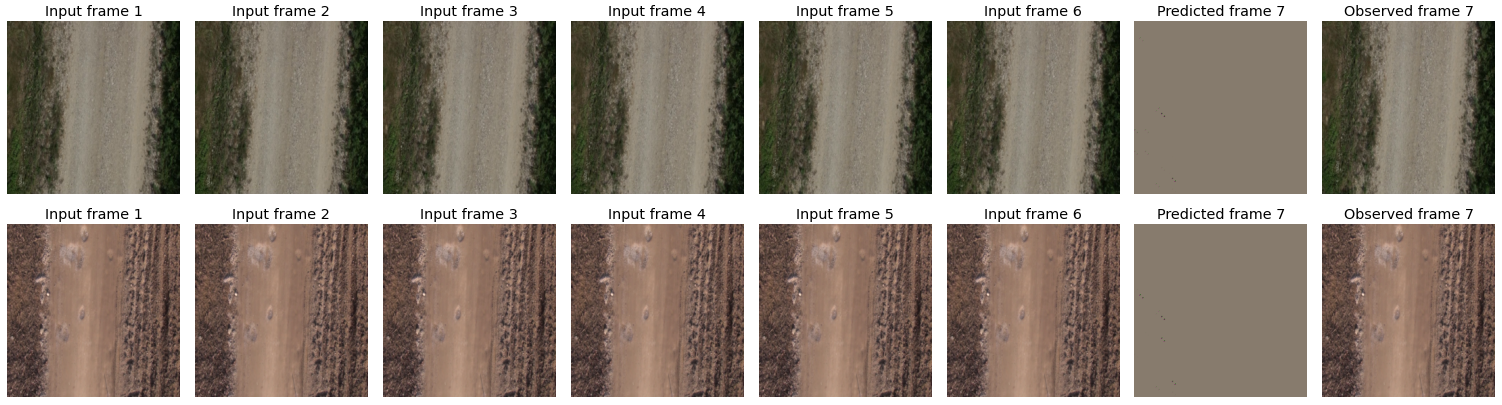

v2
* embed_dim = 64, mlp_dim = 256, patch_dim = (3, 16, 16), n_heads = 2, n_layers = 1, must_match = (8, 8)
* BCELoss of 0.6786
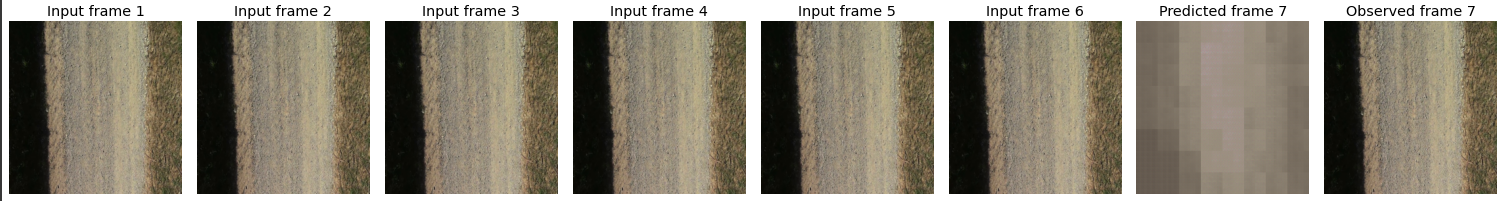

In [ ]:
model_name = 'UMCD_v1.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_dim = (6, 3, 256, 256) # (n_frames, n_channels, frame_height, frame_width)
patch_dim = (3, 16, 16) # (n_frames, patch_height, patch_width)

embedding_dim = 64
mlp_dim = 256
n_attention_heads = 2
n_transformer_layers = 1
must_match = (8, 8)

encoder = SpatioTemporal_Encoder(video_dim=video_dim, patch_dim=patch_dim, embedding_dim=embedding_dim, mlp_dim=mlp_dim, n_attention_heads=n_attention_heads, n_transformer_layers=n_transformer_layers).to(device)
decoder = SpatioTemporal_Decoder(embedding_dim=embedding_dim, must_match=must_match).to(device)
model = SpatioTemporal_AE(encoder, decoder).to(device)


print('-'*20,model_name,'-'*20)
print(f'Model parameters:\nVideo dimension:{video_dim}, Patch dimension:{patch_dim}\nEmbedding dimension:{embedding_dim}, MLP dimension:{mlp_dim}, Number of attention heads:{n_attention_heads}, Number of transformer layers:{n_transformer_layers}\n')
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in trainable_params])
print(f'Trainable params: {trainable_params:_}\n')
sample_input = torch.rand(7, 6, 3, 256, 256).to(device)
sample_output = model(sample_input)
print(f'Sample input shape: {sample_input.shape}\nSample output shape: {sample_output.shape}')
print(f'Sample output values ranging from {torch.min(sample_output).item():.5f} to {torch.max(sample_output).item():.5f}\n')

try:
  model_weights = 'UMCD_v1.pth'
  weights_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/' + model_weights
  model.load_state_dict(torch.load(weights_path, map_location=torch.device(device)), strict=False)
  print('Pretrained weights loaded sucessfully\n')
except:
  print('Could not load pretrained weights\n')

torch.cuda.empty_cache()

-------------------- UMCD_v1.pth --------------------
Model parameters:
Video dimension:(6, 3, 256, 256), Patch dimension:(3, 16, 16)
Embedding dimension:64, MLP dimension:256, Number of attention heads:2, Number of transformer layers:1

Trainable params: 301_427

Sample input shape: torch.Size([7, 6, 3, 256, 256])
Sample output shape: torch.Size([7, 1, 3, 256, 256])
Sample output values ranging from 0.00021 to 1.00000

Pretrained weights loaded sucessfully



## Initializing updated model

v3 (updated encoder & decoder)
* emb_dim = 256, mlp_dim = 256, n_heads = 2, n_layers = n, n_frames = 3
* BCELoss of 0.6681
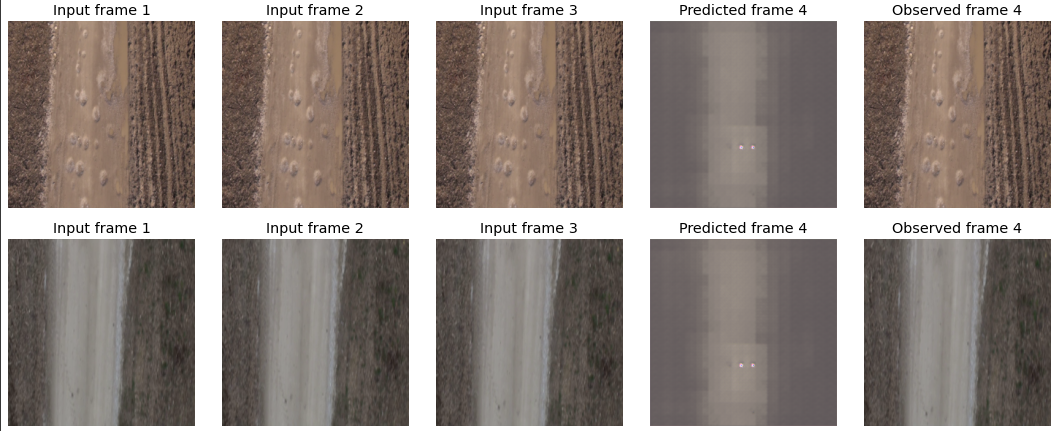

v4 
* emb_dim = 512, mlp_dim = 1024, n_heads = 2, n_layers = 2, n_frames = 3

In [ ]:
def get_valid_embedding_dims(n_max=1000, n_heads=None, must_match=(16,16)):
  n_heads = [n_heads] if n_heads else list(range(1,10))  
  return {n: [i for i in range(1, n_max + 1) if i % n == 0 and (1 / (must_match[0] * must_match[1] / i)) % 1 == 0] for n in n_heads}

for k,v in get_valid_embedding_dims().items(): 
  if len(v) > 0:
    print(f'Valid embedding dimensions for n = {k} attention heads:',v)

Valid embedding dimensions for n = 1 attention heads: [256, 512, 768]
Valid embedding dimensions for n = 2 attention heads: [256, 512, 768]
Valid embedding dimensions for n = 3 attention heads: [768]
Valid embedding dimensions for n = 4 attention heads: [256, 512, 768]
Valid embedding dimensions for n = 6 attention heads: [768]
Valid embedding dimensions for n = 8 attention heads: [256, 512, 768]


In [ ]:
frame_size = (256, 256)
patch_size = (16, 16)

emb_dim = 512
mlp_dim = 2048

n_heads = 8
n_layers = 2
n_frames = 3

encoder = SpatioTemporal_Encoder(frame_size=frame_size, patch_size=patch_size, emb_dim=emb_dim, mlp_dim=mlp_dim, n_heads=n_heads, n_layers=n_layers, n_frames=n_frames).to(device)
decoder = SpatioTemporal_Decoder(frame_size=frame_size, patch_size=patch_size, emb_dim=emb_dim, n_frames=n_frames).to(device)
model = SpatioTemporal_AE(encoder, decoder).to(device)


print('-'*20,model_name,'-'*20)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
trainable_params = sum([np.prod(p.size()) for p in trainable_params])
print(f'Trainable params: {trainable_params:_}')
try:
  model_weights = 'UMCD_v4.pth'
  weights_path = '/content/drive/MyDrive/Andreas Olsson/Public-Safety/models/' + model_weights
  model.load_state_dict(torch.load(weights_path, map_location=torch.device(device)), strict=False)
  print('Pretrained weights loaded sucessfully\n')
except:
  print('Could not load pretrained weights\n')

-------------------- UMCD_v4.pth --------------------
Trainable params: 11_405_241
Could not load pretrained weights



In [ ]:
sample_input = torch.rand(7, n_frames, 3, frame_size[0], frame_size[0]).to(device)
sample_output = model(sample_input)

print('-'*20,model_name,'-'*20)
print(f'Model parameters:\nframe_size:{frame_size}, patch_size:{patch_size}\nemb_dim:{emb_dim}, mlp_dim:{mlp_dim}, n_heads:{n_heads}, n_layers:{n_layers}\n')
print(f'Sample input shape: {sample_input.shape}\nSample output shape: {sample_output.shape}')
print(f'Sample output values ranging from {torch.min(sample_output).item():.5f} to {torch.max(sample_output).item():.5f}\n')

torch.cuda.empty_cache()

RuntimeError: ignored

## Initiate training

In [ ]:
# previous_min = np.inf
print(previous_min) 

inf


--------------------Training model UMCD_v4.pth for 7 epochs with 11_405_241 trainable params and learning rate of 0.005--------------------



Testing Epoch 1 / 7: 100%|██████████| 20/20 [01:16<00:00,  3.85s/batch, loss=0.71]


[Epoch 1]	Train loss: 0.7480	Test loss 0.7100
Sample prediction:



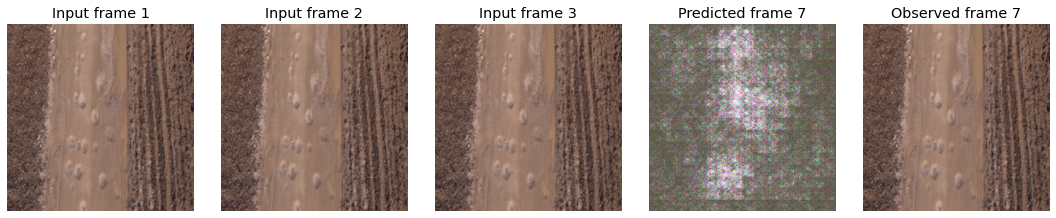


Test loss decreased (inf--->0.7100)	Saving the model...



Training Epoch 2 / 7:  58%|█████▊    | 31/53 [02:11<01:33,  4.24s/batch, loss=0.727]


RuntimeError: ignored

In [ ]:
lr = 5e-3
epochs = 7

# optim = optimizer.Adam(model.parameters(), lr=lr)
optim = optimizer.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCELoss()

previous_min = train_epochs(epochs, previous_min = previous_min)

# Results

In [ ]:
def evaluate_model():
  criterion = nn.BCELoss()
  print(f'{"-"*20}Testing model {model_name}{"-"*20}\n')
  with torch.no_grad():
    test_epoch_loss = 0
    model.eval()
    for batch in tqdm(test_dl, desc=f'Testing', position=0, leave=True):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)

      test_loss = criterion(y_hat, y)
      test_epoch_loss += test_loss.detach().cpu().item() / len(test_dl)

    print(f' ---> Test loss: {test_epoch_loss:.4f}')

# evaluate_model()

--------------------Testing model SpatioTemporal_VisionTransformer_AutoEncoder_v3.pth--------------------



Testing: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

 ---> Test loss: 0.2378


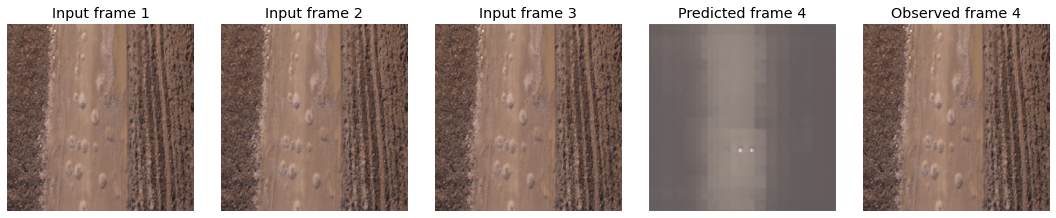

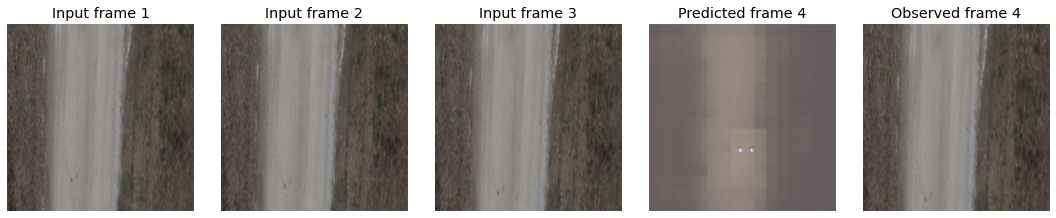

tensor(0.8448, device='cuda:0', grad_fn=<DistBackward0>)


In [ ]:
def inference(n=1):
  ps = []
  for _ in range(n):
    data = random.choice(test_dl.dataset)

    input = data[0].to(device)
    target = data[1].to(device)
    pred = model(input.unsqueeze(0).to(device))

    n = len(input) + 2
    f, axs = plt.subplots(1, n, figsize=(n*3, 3))

    for i, img in enumerate(input): 
      axs[i].imshow(cv2.cvtColor(img.cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
      axs[i].set_title(f'Input frame {i+1}')
      axs[i].axis('off')

    img = pred[0]
    axs[n-2].imshow(cv2.cvtColor(img.squeeze().detach().cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
    axs[n-2].set_title(f'Predicted frame {n-1}')
    axs[n-2].axis('off')
    ps.append(img)

    img = target
    axs[n-1].imshow(cv2.cvtColor(img.squeeze().detach().cpu().numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
    axs[n-1].set_title(f'Observed frame {n-1}')
    axs[n-1].axis('off')
    

    plt.tight_layout()
    plt.show()

  print(torch.dist(ps[0], ps[1], 2))

inference(2)